In [1]:
import numpy as np
from scipy import stats

import pymc3 as pm

import torch
import pyro
import pyro.infer as infer
import pyro.distributions as dist
from torch.distributions import constraints

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

colors = sns.color_palette().as_hex()
n_colors = len(colors)

seed = 100
np.random.seed(seed)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 二つの比率の差

- 二項分布のパラメータの差異の分布

## 問題設定

- 二つのプロセスがある
- この二つのプロセスはそれぞれN回の試行でk回の成功を生じさせる
  - 成功率はそれぞれ"独立に"決まっているとする
- それぞれの成功率とその差異を推論したい

## データ

In [2]:
n1 = 10
n2 = 10
k1 = 5
k2 = 7

## 推論（PyMC）

### モデル定義

In [3]:
with pm.Model() as model:
    theta1 = pm.Beta('theta1', 1, 1)
    theta2 = pm.Beta('theta2', 1, 1)
    
    y1 = pm.Binomial('y1', p=theta1, n=n1, observed=k1)
    y2 = pm.Binomial('y2', p=theta2, n=n2, observed=k2)
    
    delta = pm.Deterministic('delta', theta1 - theta2)

### 推論

In [4]:
with model:
    trace = pm.sample(1000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [theta2, theta1]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 5 seconds.


### 推論結果の確認

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'theta1'}>,
        <AxesSubplot:title={'center':'theta1'}>],
       [<AxesSubplot:title={'center':'theta2'}>,
        <AxesSubplot:title={'center':'theta2'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

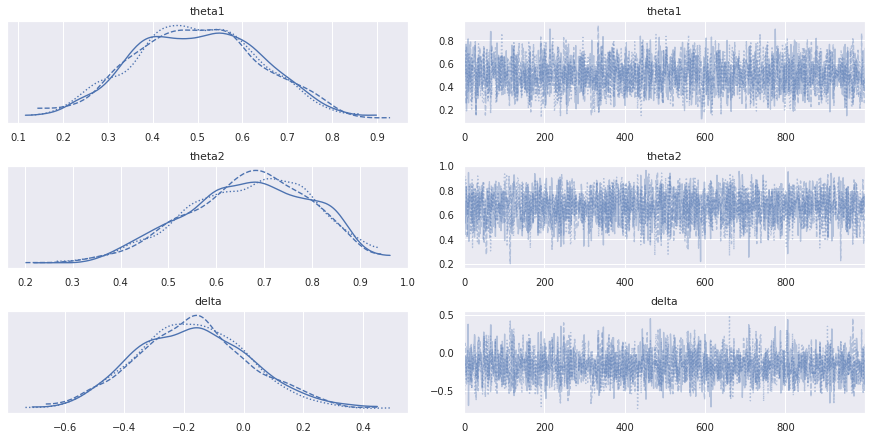

In [5]:
pm.traceplot(trace)

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'theta1'}>,
       <AxesSubplot:title={'center':'theta2'}>], dtype=object)

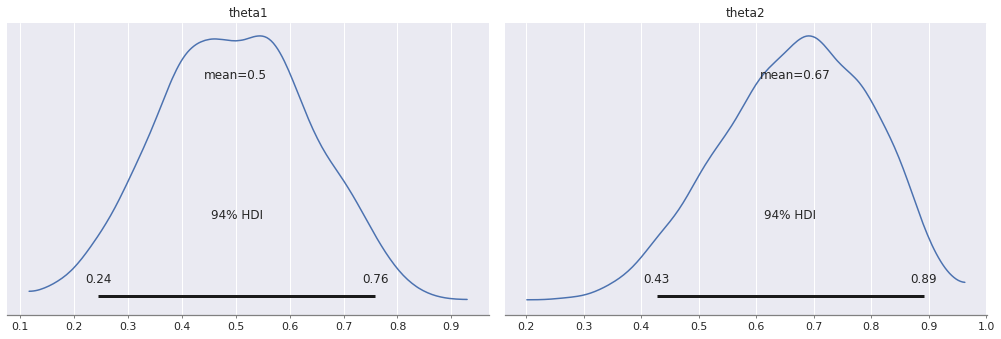

In [6]:
pm.plot_posterior(trace, var_names=['theta1', 'theta2'])

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'delta'}>], dtype=object)

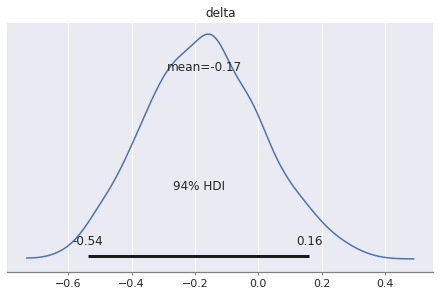

In [7]:
pm.plot_posterior(trace, var_names=['delta'])

## 推論（Pyro）

### モデル定義

In [8]:
def model_2binom(n1, n2):
    theta1 = pyro.sample('theta1', dist.Beta(torch.tensor(1.), torch.tensor(1.)))
    theta2 = pyro.sample('theta2', dist.Beta(torch.tensor(1.), torch.tensor(1.)))
    y1 = pyro.sample('y1', dist.Binomial(total_count=n1, probs=theta1))
    y2 = pyro.sample('y2', dist.Binomial(total_count=n2, probs=theta2))
    #delta = pyro.deterministic('delta', theta1 - theta2) # こうしたらできるかと思ったけどダメだった
    #delta = pyro.sample('delta', dist.Delta(theta1-theta2)) # こうしたらできるかと思ったけどダメだった
    return y1, y2

cond_model = pyro.condition(
    model_2binom, 
    data={'y1':torch.tensor(float(k1)), 
          'y2':torch.tensor(float(k2))})

### 推論

In [9]:
nuts_kernel = infer.NUTS(cond_model, 
                         adapt_step_size=True, 
                         jit_compile=True, 
                         ignore_jit_warnings=True)
mcmc = infer.MCMC(nuts_kernel, 
                  num_samples=1000,
                  warmup_steps=500,
                  num_chains=1)

mcmc.run(n1=n1, n2=n2)

Sample: 100%|██████████| 1500/1500 [00:12, 123.20it/s, step size=9.13e-01, acc. prob=0.917]


### 推論結果の確認

In [10]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      0.49      0.14      0.49      0.25      0.69    619.55      1.01
    theta2      0.67      0.14      0.68      0.46      0.91    943.76      1.00

Number of divergences: 0


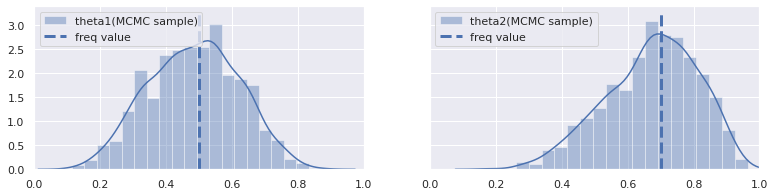

In [11]:
theta1_sample_mcmc = mcmc.get_samples()['theta1']
theta2_sample_mcmc = mcmc.get_samples()['theta2']

fig = plt.figure(figsize=(13, 3))
ax = fig.subplots(1,2, sharey=True, sharex=True)
sns.distplot(theta1_sample_mcmc, ax=ax[0], label='theta1(MCMC sample)')
sns.distplot(theta2_sample_mcmc, ax=ax[1], label='theta2(MCMC sample)')

xmin, xmax, ymin, ymax = ax[0].axis()
ax[0].vlines(k1/n1, ymin, ymax, linestyles='dashed', lw=3, label='freq value')
ax[1].vlines(k2/n2, ymin, ymax, linestyles='dashed', lw=3, label='freq value')

ax[0].set_xlim(0, 1)
ax[0].legend()
ax[1].legend()

<AxesSubplot:>

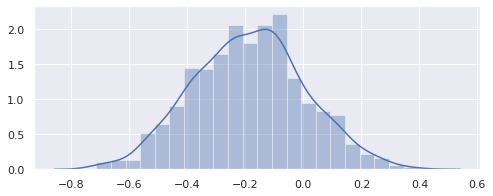

In [12]:
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)

delta = theta1_sample_mcmc - theta2_sample_mcmc
sns.distplot(delta, ax=ax, label='delta')